In [1]:
from base64 import b64encode

import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer, logging

from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
import os

torch.manual_seed(1)
logging.set_verbosity_error()

torch_device = "cuda" if torch.cuda.is_available else "cpu"
torch_device

c:\Users\TYC\Desktop\python code\hugging face\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'cuda'

In [2]:
#loading all components

#vae
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

#tokenizer and text encoder
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

#unet
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

#noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

#all to gpu
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)


C:\Users\TYC\AppData\Local\Temp\ipykernel_20164\2138708465.py:34: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),
100%|██████████| 30/30 [03:00<00:00,  6.03s/it]


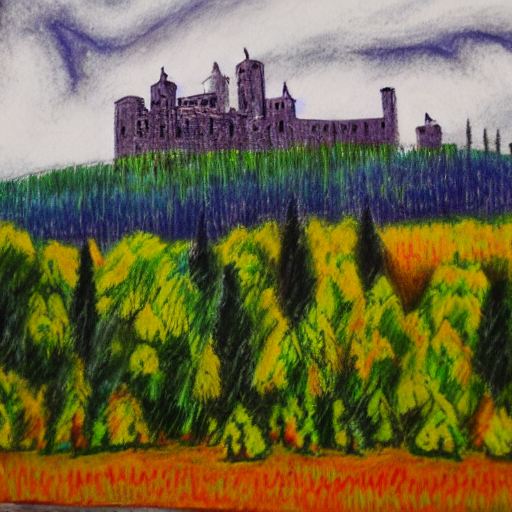

In [3]:
#diffusion loop

prompt = ["An oil pastel painting of a rural Bavarian mountianous forest with castles and foliage"]
height = 512
width = 512
num_inference_steps = 30
guidance_scale = 7.5
generator = torch.manual_seed(32)
batch_size = 1

#preparing text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#preparing scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)

set_timesteps(scheduler, num_inference_steps)

#preparing latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma #scaling

#sampling loop
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

        #expand
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        #predict
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        #guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)  

        #x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

#scale and decode
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

#display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]

pil_images[0]




In [4]:
#vae property
def pil_to_latent(input_im):
    #to (1, 4, 64, 64)
    with torch.no_grad():
        latent = vae.encode(tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1) #scale

    return 0.18215 * latent.latent_dist.sample()

def latent_to_pil(latents):
    latents = (1 / 0.18215) * latents

    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]

    return pil_images

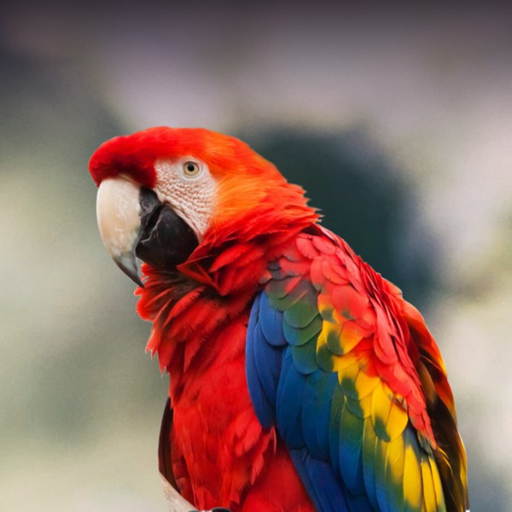

In [5]:
#download
import requests
from io import BytesIO

url = 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'
def download_image(url):
    
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")

input_image = download_image(url).resize((512, 512))
input_image 

In [6]:
#try vae
#encode
encoded = pil_to_latent(input_image)
print(encoded.shape)

torch.Size([1, 4, 64, 64])


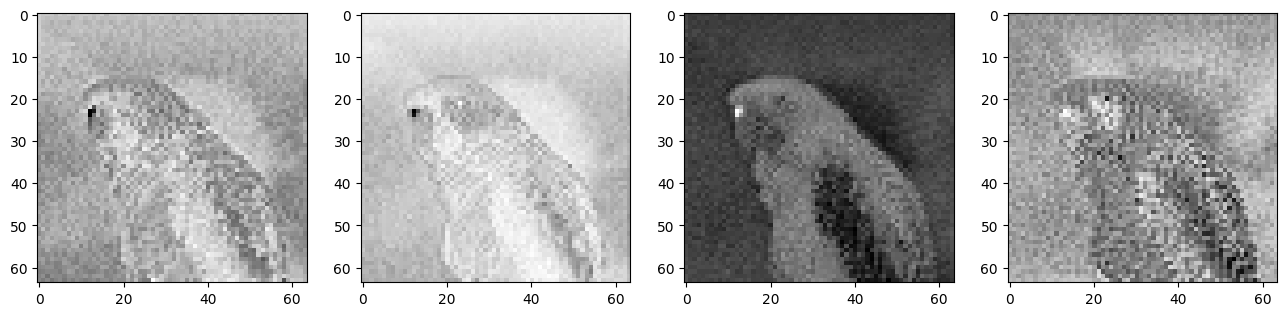

In [7]:
#look at the 4 encoded channels
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

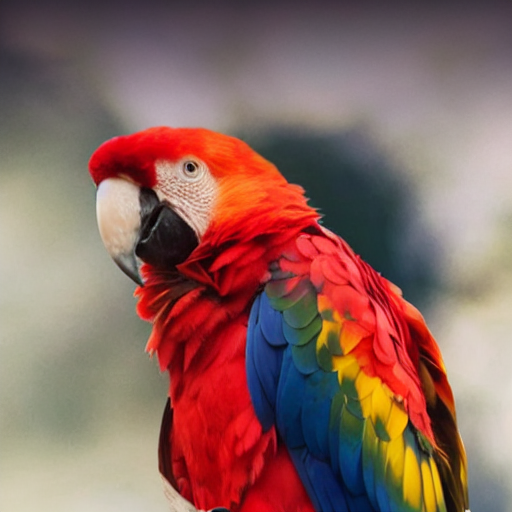

In [8]:
#decode back
decoded = latent_to_pil(encoded)[0]
decoded

In [9]:
#setting timestep
set_timesteps(scheduler, 15)

In [10]:
#check
scheduler.timesteps

tensor([999.0000, 927.6429, 856.2857, 784.9286, 713.5714, 642.2143, 570.8571,
        499.5000, 428.1429, 356.7857, 285.4286, 214.0714, 142.7143,  71.3571,
          0.0000])

In [11]:
#amount of noise present at each timesteps
scheduler.sigmas

tensor([14.6146,  9.6826,  6.6780,  4.7746,  3.5221,  2.6666,  2.0606,  1.6156,
         1.2768,  1.0097,  0.7913,  0.6056,  0.4397,  0.2780,  0.0292,  0.0000])

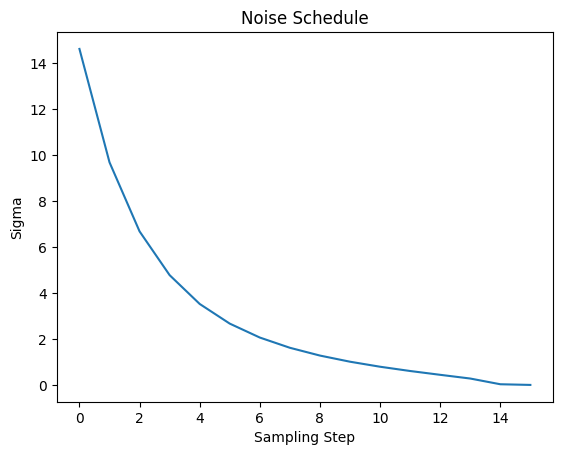

In [12]:
#plotting noise schedule
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling Step')
plt.ylabel('Sigma')
plt.show()

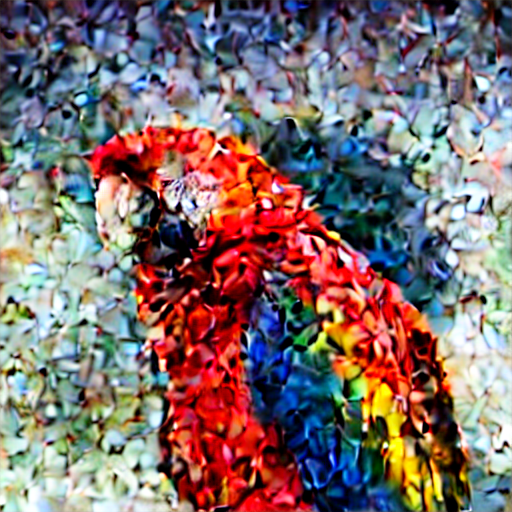

In [13]:
noise = torch.randn_like(encoded)
sampling_step = 10 #test noise adding at one timestep
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[sampling_step]]))
latent_to_pil(encoded_and_noised.float())[0]

In [15]:
#img2img
prompt = ["A phoenix of the orient"]
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1

#preparing text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size,  padding="max_length", max_length=max_length, return_tensors="pt")

with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

#combine embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

#preparing scheduler
set_timesteps(scheduler, num_inference_steps)

#preparing latents
start_step = 10
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]])) #start from a noised and encoded parrot image
latents = latents.to(torch_device).float()

#sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step: #only starts to denoise when i is 10 or more

        #expand
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        #predict noise
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]
        
        #guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        #x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

latent_to_pil(latents)

100%|██████████| 50/50 [08:59<00:00, 10.79s/it]


[<PIL.Image.Image image mode=RGB size=512x512>]

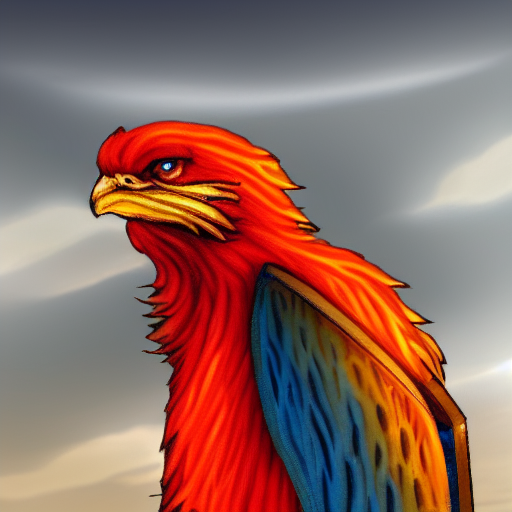

In [16]:
latent_to_pil(latents)[0]

In [17]:
#exploring text embedding
prompt = "picture of a puppy"

In [18]:
#tokenize prompt
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input['input_ids'][0] #view tokens

tensor([49406,  1674,   539,   320,  6829, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407, 49407])

In [19]:
#view token descriptions
for t in text_input['input_ids'][0][:8]: #first 8
    print(t, tokenizer.decoder.get(int(t)))


tensor(49406) <|startoftext|>
tensor(1674) picture</w>
tensor(539) of</w>
tensor(320) a</w>
tensor(6829) puppy</w>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>
tensor(49407) <|endoftext|>


In [20]:
#look at the final output of text encoder model
output_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
print("Shape:", output_embeddings.shape)
output_embeddings

Shape: torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0798, -0.2392,  0.8597,  ..., -1.3157, -0.1874, -0.3978],
         [-0.7559,  0.8930,  0.0249,  ..., -0.6313, -1.3566, -1.3027],
         ...,
         [-0.1735, -0.1027,  0.0590,  ..., -0.8509, -1.4867, -0.4892],
         [-0.1564, -0.1237,  0.0687,  ..., -0.8536, -1.4762, -0.4813],
         [-0.1892, -0.0778,  0.1174,  ..., -0.8416, -1.4603, -0.5138]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [21]:
#view the embeddings on the mode'
text_encoder.text_model.embeddings

CLIPTextEmbeddings(
  (token_embedding): Embedding(49408, 768)
  (position_embedding): Embedding(77, 768)
)

In [22]:
#access embedding layer
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_emb_layer

Embedding(49408, 768)

In [23]:
#embed the token of puppy (6829)
embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
embedding.shape

torch.Size([768])

In [24]:
#embed all tokens in the prompt 
token_embeddings = token_emb_layer(text_input.input_ids.to(torch_device))
print(token_embeddings.shape)
token_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0011,  0.0032,  0.0003,  ..., -0.0018,  0.0003,  0.0019],
         [ 0.0235, -0.0118,  0.0110,  ...,  0.0049,  0.0078,  0.0160],
         [ 0.0102,  0.0066, -0.0016,  ...,  0.0019,  0.0101,  0.0016],
         ...,
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052],
         [ 0.0012,  0.0077, -0.0011,  ..., -0.0015,  0.0009,  0.0052]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [25]:
#positional embeddings
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
pos_emb_layer

Embedding(77, 768)

In [26]:
#get pos emb for each position
position_ids = text_encoder.text_model.embeddings.position_ids[:, :77]
position_embeddings = pos_emb_layer(position_ids)
print(position_embeddings.shape)
position_embeddings

torch.Size([1, 77, 768])


tensor([[[ 0.0016,  0.0020,  0.0002,  ..., -0.0013,  0.0008,  0.0015],
         [ 0.0042,  0.0029,  0.0002,  ...,  0.0010,  0.0015, -0.0012],
         [ 0.0018,  0.0007, -0.0012,  ..., -0.0029, -0.0009,  0.0026],
         ...,
         [ 0.0216,  0.0055, -0.0101,  ..., -0.0065, -0.0029,  0.0037],
         [ 0.0188,  0.0073, -0.0077,  ..., -0.0025, -0.0009,  0.0057],
         [ 0.0330,  0.0281,  0.0289,  ...,  0.0160,  0.0102, -0.0310]]],
       device='cuda:0', grad_fn=<EmbeddingBackward0>)

In [27]:
#combining the 2 to get the the final output embeddings
input_embeddings = token_embeddings + position_embeddings
print(input_embeddings.shape)
print(input_embeddings)

#compare with the straight forward method
text_encoder.text_model.embeddings(text_input.input_ids.to(torch_device))

torch.Size([1, 77, 768])
tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 2.7755e-02, -8.8811e-03,  1.1211e-02,  ...,  5.9235e-03,
           9.2485e-03,  1.4819e-02],
         [ 1.2047e-02,  7.3035e-03, -2.8114e-03,  ..., -1.0419e-03,
           9.1857e-03,  4.1439e-03],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)


tensor([[[ 2.6770e-03,  5.2133e-03,  4.9323e-04,  ..., -3.1321e-03,
           1.0659e-03,  3.4316e-03],
         [ 2.7755e-02, -8.8811e-03,  1.1211e-02,  ...,  5.9235e-03,
           9.2485e-03,  1.4819e-02],
         [ 1.2047e-02,  7.3035e-03, -2.8114e-03,  ..., -1.0419e-03,
           9.1857e-03,  4.1439e-03],
         ...,
         [ 2.2781e-02,  1.3262e-02, -1.1241e-02,  ..., -8.0054e-03,
          -2.0560e-03,  8.9366e-03],
         [ 2.0026e-02,  1.5015e-02, -8.7638e-03,  ..., -4.0313e-03,
           1.8487e-05,  1.0885e-02],
         [ 3.4206e-02,  3.5826e-02,  2.7768e-02,  ...,  1.4465e-02,
           1.1110e-02, -2.5745e-02]]], device='cuda:0', grad_fn=<AddBackward0>)

In [28]:
def get_output_embeds(input_embeddings):
   
    bsz, seq_len = input_embeddings.shape[:2]

    #causal attention mask (lower triangular)
    causal_attention_mask = torch.full((bsz, 1, seq_len, seq_len), float("-inf"), device=input_embeddings.device)
    causal_attention_mask = torch.triu(causal_attention_mask, diagonal=1)

    # Getting the output embeddings involves calling the model with passing output_hidden_states=True
    # so that it doesn't just return the pooled final predictions:
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None, # We aren't using an attention mask so that can be None
        causal_attention_mask=causal_attention_mask.to(torch_device),
        output_attentions=None,
        output_hidden_states=True, # We want the output embs not the final output
        return_dict=None,
    )

    # final output hidden state
    output = encoder_outputs[0]

    # layer norm
    output = text_encoder.text_model.final_layer_norm(output)

    return output

out_embs_test = get_output_embeds(input_embeddings) # Feed through the model with our new function
print(out_embs_test.shape) # Check the output shape
out_embs_test # Inspect the output


torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0798, -0.2392,  0.8597,  ..., -1.3157, -0.1874, -0.3978],
         [-0.7559,  0.8930,  0.0249,  ..., -0.6313, -1.3566, -1.3027],
         ...,
         [-0.1735, -0.1027,  0.0590,  ..., -0.8509, -1.4867, -0.4892],
         [-0.1564, -0.1237,  0.0687,  ..., -0.8536, -1.4762, -0.4813],
         [-0.1892, -0.0778,  0.1174,  ..., -0.8416, -1.4603, -0.5138]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [45]:
prompt = "A picture of a puppy"

#tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

#get embeddings
token_embeddings = token_emb_layer(input_ids)

#try replace the puppy token with an arbitrary  token 2368
replacement_tokem_embedding = text_encoder.get_input_embeddings()(torch.tensor(2368, device=torch_device))

#swap
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_tokem_embedding.to(torch_device)

#combine
input_embeddings = token_embeddings + position_embeddings

#feed through model
modified = get_output_embeds(input_embeddings)

print(modified.shape)
modified

torch.Size([1, 77, 768])


tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.6034, -0.5322,  0.0629,  ..., -0.3964,  0.0877, -0.9558],
         [-0.5936, -0.5407,  0.0731,  ..., -0.3876,  0.0906, -0.9436],
         [-0.6393, -0.4703,  0.1103,  ..., -0.3904,  0.1351, -0.9726]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)

In [46]:
#generate image with a modified token
def generate_with_embs(text_embeddings):
    height = 512
    width  = 512
    num_inference_steps = 30
    guidance_scale = 7.5
    generator = torch.manual_seed(32)
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]

    #tokenize
    uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt")

    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    #scheduler
    set_timesteps(scheduler, num_inference_steps)

    #latents
    latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    #sampling loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand 
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict 
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latent_to_pil(latents)[0]

C:\Users\TYC\AppData\Local\Temp\ipykernel_20164\3732102293.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)
100%|██████████| 30/30 [06:45<00:00, 13.50s/it]


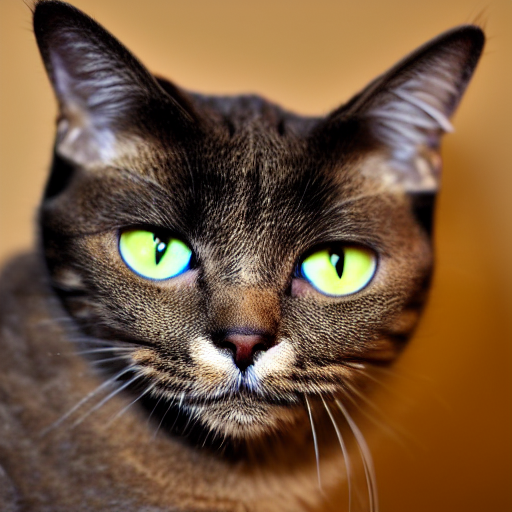

In [47]:
generate_with_embs(modified)

In [35]:
# create a chimera of an animal

#checking token
prompt = "dragon"
print(tokenizer(prompt))
print(token_emb_layer(torch.tensor([8797], device=torch_device)).shape)

{'input_ids': [49406, 5471, 49407], 'attention_mask': [1, 1, 1]}
torch.Size([1, 768])


C:\Users\TYC\AppData\Local\Temp\ipykernel_20164\3732102293.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)
100%|██████████| 30/30 [06:51<00:00, 13.71s/it]


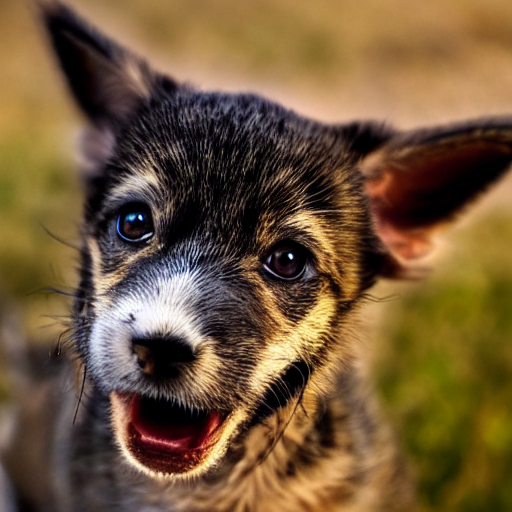

In [36]:
prompt = "A picture of a puppy"

#tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

#get embedding
token_embeddings = token_emb_layer(input_ids)

#puppy embedding and dragon embedding
puppy_token_embedding = token_emb_layer(torch.tensor(6829, device=torch_device))
dragon_token_embedding = token_emb_layer(torch.tensor(5471, device=torch_device))

#mix puppy and dragon
replacement_token_embedding = 0.5 * puppy_token_embedding + 0.5 * dragon_token_embedding

#insert token
token_embeddings[0, torch.where(input_ids[0]==6829)] = replacement_token_embedding.to(torch_device)

#plus pos emb
input_embeddings = token_embeddings + position_embeddings

#get final output emb
modified = get_output_embeds(input_embeddings)

#generate
generate_with_embs(modified)

C:\Users\TYC\AppData\Local\Temp\ipykernel_20164\3732102293.py:24: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)
100%|██████████| 30/30 [06:45<00:00, 13.51s/it]


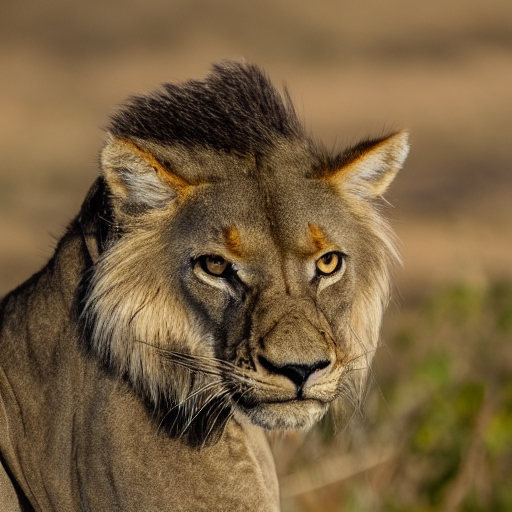

In [44]:
#try mix prompt with mix factor
text_1 = tokenizer(["A majestic male lion"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_2 = tokenizer(["A venomous king cobra"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    emb_1 = text_encoder(text_1.input_ids.to(torch_device))[0]
    emb_2 = text_encoder(text_2.input_ids.to(torch_device))[0]

#mixing
mix_factor = 0.45
mixed_emb = (emb_1 * mix_factor + emb_2 * (1 - mix_factor))

#generate
generate_with_embs(mixed_emb)

In [39]:
#prepare scheduler
set_timesteps(scheduler, num_inference_steps)

#latent
latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

#text embeddings
text_input = tokenizer(['An oriental dragon as a creature of unrivalled reverance'], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]


#unet
with torch.no_grad():
    noise_pred = unet(latents, t, encoder_hidden_states=text_embeddings)["sample"]

latents.shape, noise_pred.shape

C:\Users\TYC\AppData\Local\Temp\ipykernel_20164\971594935.py:5: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn((batch_size, unet.in_channels, height//8, width//8), generator=generator)


(torch.Size([1, 4, 64, 64]), torch.Size([1, 4, 64, 64]))

In [40]:
#color guidance
def blue_loss(image):
    error = torch.abs(image[:,2] - 0.9).mean() #[:, 2] means all of only blue channel

    return error

C:\Users\TYC\AppData\Local\Temp\ipykernel_20164\1469446671.py:29: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  latents = torch.randn(batch_size, unet.in_channels, height//8, width//8, generator=generator)
  0%|          | 0/50 [00:00<?, ?it/s]

0 loss: 159.06436157226562


 22%|██▏       | 11/50 [03:44<15:17, 23.51s/it]

10 loss: 29.74048614501953


 42%|████▏     | 21/50 [06:57<11:20, 23.45s/it]

20 loss: 8.9407958984375


 62%|██████▏   | 31/50 [10:11<07:25, 23.47s/it]

30 loss: 7.548251628875732


 82%|████████▏ | 41/50 [13:25<03:31, 23.45s/it]

40 loss: 6.753127098083496


100%|██████████| 50/50 [16:00<00:00, 19.21s/it]


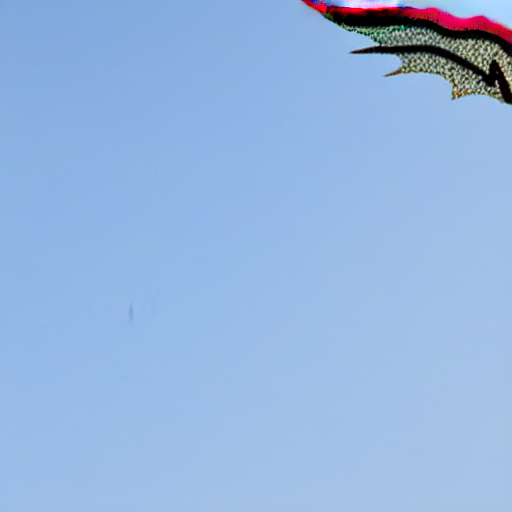

In [48]:
prompt = 'An oriental dragon as a creature of unrivalled reverance'
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1
blue_loss_scale = 200

#text
text = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    text_emb = text_encoder(text.input_ids.to(torch_device))[0]

#uncond text
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
    uncond_emb = text_encoder(uncond_input.input_ids.to(torch_device))[0]

text_emb = torch.cat([uncond_emb, text_emb])

#scheduler
set_timesteps(scheduler, num_inference_steps)

#latents
latents = torch.randn(batch_size, unet.in_channels, height//8, width//8, generator=generator)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma

#sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):

    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)
    sigma = scheduler.sigmas[i]

    #predict noise
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_emb)["sample"]

    #guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #color loss guidance
    if i % 5 == 0: #performed every 5 steps
        latents = latents.detach().requires_grad_()

        #x_0
        latents_x0 = latents - sigma * noise_pred

        #decoded back to image
        denoised_image = vae.decode((1 / 0.18215) * latents_x0).sample / 2 + 0.5 #range (0, 1)

        #calculate loss
        loss = blue_loss(denoised_image) * blue_loss_scale

        #print every 10 steps
        if i % 10 == 0:
            print(i, 'loss:', loss.item())
        
        #grad
        cond_grad = torch.autograd.grad(loss, latents)[0]

        #modify latents
        latents = latents.detach() - cond_grad * sigma**2

    latents = scheduler.step(noise_pred, t, latents).prev_sample

latent_to_pil(latents)[0]